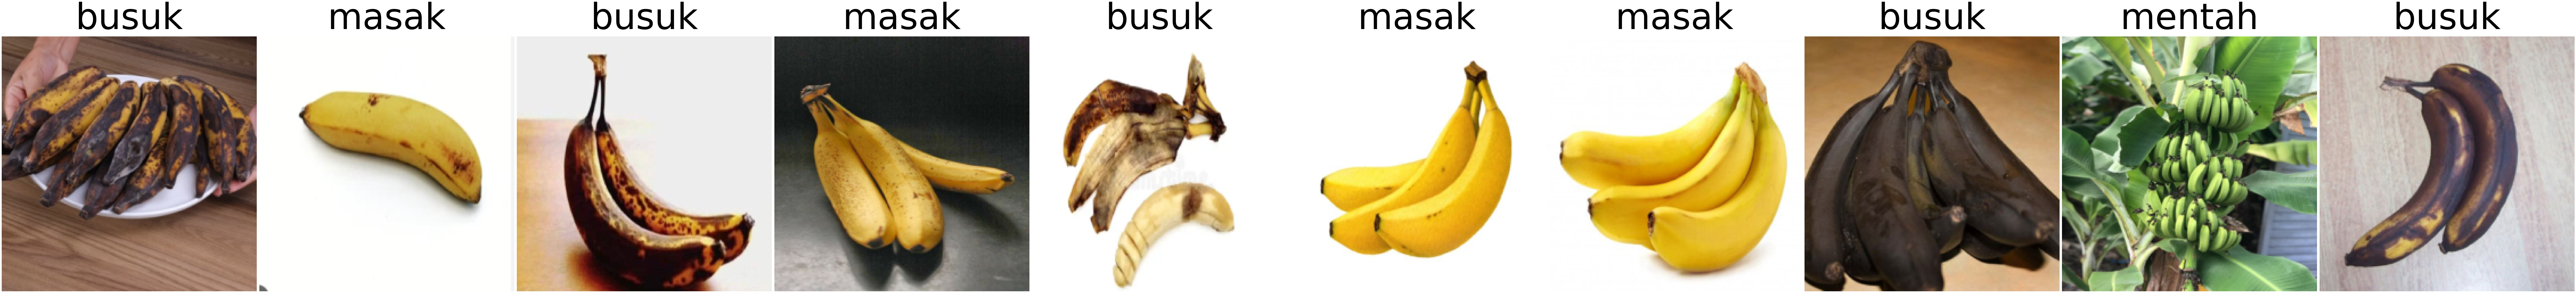

Train size: 230
Validation size: 49
Test size: 51


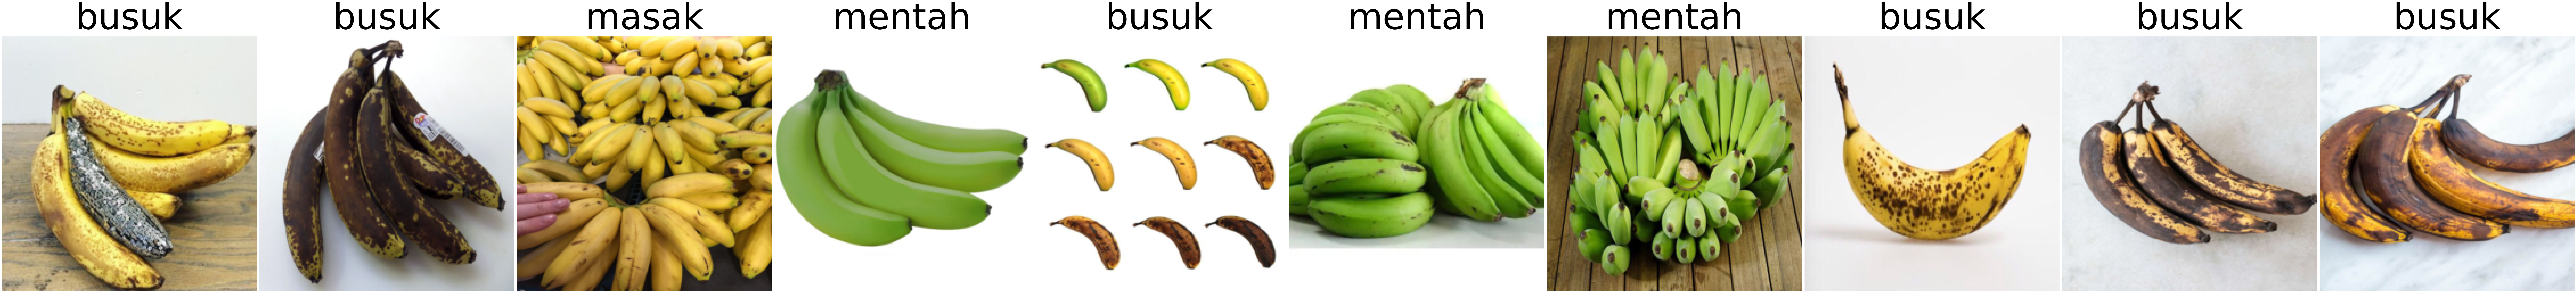

c:\Users\secon\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10 | Train Loss: 0.7656, Train Accuracy: 0.6609 | Validation Loss: 0.5022, Validation Accuracy: 0.7755
Epoch 2/10 | Train Loss: 0.1658, Train Accuracy: 0.9391 | Validation Loss: 0.3737, Validation Accuracy: 0.8367
Epoch 3/10 | Train Loss: 0.0617, Train Accuracy: 0.9826 | Validation Loss: 0.2866, Validation Accuracy: 0.9184
Epoch 4/10 | Train Loss: 0.0474, Train Accuracy: 0.9783 | Validation Loss: 0.2795, Validation Accuracy: 0.8980
Epoch 5/10 | Train Loss: 0.0242, Train Accuracy: 1.0000 | Validation Loss: 0.2710, Validation Accuracy: 0.8980
Epoch 6/10 | Train Loss: 0.0378, Train Accuracy: 0.9826 | Validation Loss: 0.2430, Validation Accuracy: 0.8980
Epoch 7/10 | Train Loss: 0.0185, Train Accuracy: 1.0000 | Validation Loss: 0.2237, Validation Accuracy: 0.9184
Epoch 8/10 | Train Loss: 0.0144, Train Accuracy: 1.0000 | Validation Loss: 0.2264, Validation Accuracy: 0.9184


In [ ]:
import os
import random
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def load_data(directory, image_size, batch_size):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    dataset = datasets.ImageFolder(root=directory, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader, dataset

def visualize_data_random(dataset, num_images, image_size, labels=None):
    plt.figure(figsize=(image_size, image_size))
    indices = random.sample(range(len(dataset)), num_images)  # Random indices
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        title = labels[label] if labels else f"Label: {label}"
        plt.title(title, fontsize=150)  # Increase font size
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def prepare_data(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    total_size = len(dataset)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

def create_alexnet_model(num_classes):
    model = models.alexnet(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save the model
    torch.save(model.state_dict(), save_path)

    # Visualize metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss per Epoch")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy per Epoch")

    plt.tight_layout()
    plt.show()

# Example usage
data_directory = r"D:\perkuliahan\semester 5\PMDPM\UAS\DATASET PISANG"
image_size = 224
batch_size = 32

# Load and normalize data
data_loader, dataset = load_data(data_directory, image_size, batch_size)

# Visualize normalized data
visualize_data_random(dataset, num_images=10, image_size=150, labels=dataset.classes)

# Prepare data (split into train, val, test)
train_dataset, val_dataset, test_dataset = prepare_data(dataset)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Visualize a batch from the training set
visualize_data_random(train_dataset, num_images=10, image_size=150, labels=dataset.classes)

# Model creation
num_classes = len(dataset.classes)
model = create_alexnet_model(num_classes)

# Compile model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

# Prepare DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train the model
num_epochs = 10
save_path = "alexnet_model.pth"
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path)

# Display model summary
print(model)


In [ ]:
import onnx
import torch.onnx
from onnx2keras import onnx_to_keras
import tensorflow as tf

def save_model_as_h5(model, dummy_input, h5_path):
    # Export the PyTorch model to ONNX format
    onnx_path = "temp_model.onnx"
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
    )

    # Load ONNX model
    onnx_model = onnx.load(onnx_path)

    # Convert ONNX model to Keras model
    keras_model = onnx_to_keras(onnx_model, ['input'])

    # Save Keras model to H5 format
    keras_model.save(h5_path)
    print(f"Model saved as {h5_path}")

# Define a dummy input for tracing (size should match the input dimensions of the model)
dummy_input = torch.randn(1, 3, image_size, image_size)

# Save the trained model as H5
h5_path = "alexnet2_model.h5"
save_model_as_h5(model, dummy_input, h5_path)


C:\Users\secon\AppData\Local\Temp\ipykernel_9976\1547341142.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


True Label: busuk, Predicted: busuk
True Label: mentah, Predicted: mentah
True Label: masak, Predicted: masak
True Label: busuk, Predicted: busuk
True Label: mentah, Predicted: mentah


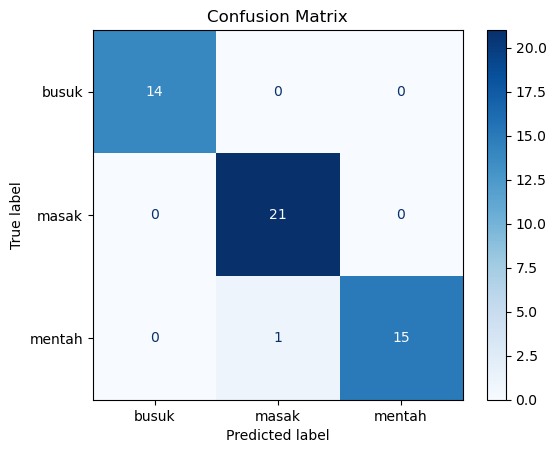

In [ ]:
import os
import random
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def load_data(directory, image_size, batch_size):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    dataset = datasets.ImageFolder(root=directory, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader, dataset

def visualize_data_random(dataset, num_images, image_size, labels=None):
    plt.figure(figsize=(image_size, image_size))
    indices = random.sample(range(len(dataset)), num_images)  # Random indices
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        title = labels[label] if labels else f"Label: {label}"
        plt.title(title, fontsize=10)  # Increase font size
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def prepare_data(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    total_size = len(dataset)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

def create_alexnet_model(num_classes):
    model = models.alexnet(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model

def evaluate_model(model, test_loader, device, labels):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    # Display sample predictions
    indices = random.sample(range(len(all_preds)), 5)
    for idx in indices:
        print(f"True Label: {labels[all_labels[idx]]}, Predicted: {labels[all_preds[idx]]}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Visualize confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Example usage
data_directory = r"D:\perkuliahan\semester 5\PMDPM\UAS\DATASET PISANG"
image_size = 224
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and normalize data
data_loader, dataset = load_data(data_directory, image_size, batch_size)

# Prepare data (split into train, val, test)
train_dataset, val_dataset, test_dataset = prepare_data(dataset)

# Create test DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model creation
num_classes = len(dataset.classes)
model = create_alexnet_model(num_classes)
model.to(device)

# Load saved model
model_path = "alexnet_model.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))

# Evaluate model
evaluate_model(model, test_loader, device, labels=dataset.classes)


In [13]:
import h5py

def save_model_to_h5(model, model_path_h5):
    """
    Save a PyTorch model in .h5 format.

    Parameters:
        model (torch.nn.Module): The PyTorch model to save.
        model_path_h5 (str): Path to save the .h5 file.

    Returns:
        None
    """
    with h5py.File(model_path_h5, "w") as h5f:
        for name, param in model.state_dict().items():
            h5f.create_dataset(name, data=param.cpu().numpy())

def load_model_from_h5(model, model_path_h5):
    """
    Load a PyTorch model from a .h5 file.

    Parameters:
        model (torch.nn.Module): The PyTorch model to load weights into.
        model_path_h5 (str): Path to the .h5 file.

    Returns:
        model (torch.nn.Module): The model with loaded weights.
    """
    with h5py.File(model_path_h5, "r") as h5f:
        for name, param in model.state_dict().items():
            param.copy_(torch.tensor(h5f[name][:]))
    return model

# Save the model in .h5 format
model_path_h5 = "BestModel_AlexNet CNN_A_Keras.h5"
save_model_to_h5(model, model_path_h5)
print(f"Model saved in .h5 format at: {model_path_h5}")

# Load the model from .h5 format (optional)
loaded_model = create_alexnet_model(num_classes)
loaded_model = load_model_from_h5(loaded_model, model_path_h5)
loaded_model.to(device)


Model saved in .h5 format at: BestModel_AlexNet CNN_A_Keras.h5


c:\Users\secon\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\secon\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 